[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1hTIlhhe96mwj1xBRx3xaYBFKVNrhL4tP/view?usp=sharing)

# **Libraries**

In [ ]:
# Import dependencies
from google.colab import files ## Upload file(s) from local
import zipfile ## Unzip zip file(s)
import os ## Interact with file system
import shutil ## Copy file(s)

## Plot image(s)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np ## Images array handle
import tensorflow as tf ## Deep learning library
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator ## Image preprocess and augmentation

import random ## Get random image(s)
import tempfile ## Generate temporary files and directories

# **Data Preperation**

Source Dataset from Kaggle :

[Paddy Dataset](https://www.kaggle.com/competitions/paddy-disease-classification/data)

In [ ]:
# Set Kaggle API
## Installation
! pip install kaggle

## Upload Kaggle API token (.json format) from user's profile 'Create API Token'
files.upload() ### Upload files button appears for import the .json file from local 

## Create a folder for specific Kaggle API location
! mkdir ~/.kaggle

## Copy the uploaded API token to the created folder
! cp kaggle.json ~/.kaggle/

## Modify file permission and ensure user's credential security
! chmod 600 ~/.kaggle/kaggle.json 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [ ]:
# Create a helper function to unzip file(s)
def unzip(zipfile_name_list):
  """
  Params:
          zipfile_name_list: List contains zipfile name without .zip extensions
  """
  ## Iterate over passed list
  for file in zipfile_name_list:
    ## Merge zipfile name with .zip extension
    file_zip = str(file) + '.zip'
    ## Try open zipfile with read 'r' mode
    try:
      zip_ref = zipfile.ZipFile(file_zip, 'r')
    except:
      print("Something went wrong when read to the unzip file")
    ## Extract readed zipfile by pass the destination path
    zip_ref.extractall('./' + file + '/')
    ## Close read mode
    zip_ref.close()

# Create a function to download and unzip Kaggle dataset by passed its webpage address link
def download_and_unzip_dataset(*dataset_link):
  """
  Params:
          *dataset_link: Kaggle dataset link(s) separate with commas and enclosed by string
  """
  ## Create empty list to collect zipfile name
  zipfile_name = [] 
  ## Iterate over passed Kaggle dataset link/address
  for link in dataset_link:
    ## Split address by forward slash
    slash_split = str(link).split('/')
    ## Set conditions to provide datasets download from either Kaggle regular datasets or competitions webpage
    if slash_split[-3] != 'datasets' and slash_split[-3] != 'competitions':
      ## Raise exception error if addresses are not as expected Kaggle webpage address format
      raise Exception('Link(s) format are not as expected')
    ## Set conditions for Kaggle regular datasets download
    if slash_split[-3] == 'datasets':
      ## Construct a formatted dataset name
      dataset_name = slash_split[-2] + '/' + slash_split[-1]
      ## Do bash command to download datasets
      ! kaggle datasets download $dataset_name
    ## Set conditions for Kaggle competitions datasets download
    if slash_split[-3] == 'competitions':
      ## Construct a formatted dataset name
      dataset_name = slash_split[-2]
      ## Do bash command to download datasets
      ! kaggle competitions download -c $dataset_name 
    ## Append last split space as zipfile name
    zipfile_name.append(dataset_name)
  ## Execute the created helper function to unzip downloaded file(s)
  unzip(zipfile_name)

In [ ]:
# Download the appropriate dataset(s) by pass its Kaggle webpage link to the created function 
## Download the Paddy dataset from Kaggle
download_and_unzip_dataset('https://www.kaggle.com/competitions/paddy-disease-classification/data')

 99% 1.01G/1.02G [00:31<00:00, 47.1MB/s]
100% 1.02G/1.02G [00:31<00:00, 34.7MB/s]


In [ ]:
# Copy image class(es) to appropriate folder also the class name that are desired 
def move_image(src_dir, classname_list, destination_root_dir):
  """
  Params:
          src_dir: Root directory of source, enclosed by string
          classname_list : List contains desired name of class(es), ordered alphabetically
          destination_root_dir : Root directory of destination
  """ 
  ## Ensure the destination root directory is exist
  if not os.path.exists(destination_root_dir):
    ## Create if doesn't exist
    os.makedirs(destination_root_dir)
  ## Create source classname list which is alphabetically sorted  
  class_src = sorted([dirs for root, dirs, files in os.walk(src_dir)][0])
  ## Iterate over passed classname_list index
  for index in range(len(classname_list)):
    ## Ensure the desired classname in destination root directory is exist
    if os.path.exists(os.path.join(destination_root_dir, str(classname_list[index]))):
      ## Create if doesn't exist
      os.makedirs(os.path.join(destination_root_dir, str(classname_list[index])))
    ## Ensure the number of source and desired classes are equal 
    if len(class_src) == len(classname_list):
      ## Copy each class directory
      shutil.copytree(os.path.join(src_dir, str(class_src[index])),
                      os.path.join(destination_root_dir, str(classname_list[index])))
    ## Set condition the number of source and desired classes are not equal 
    else:
      ## Raise an exception
      raise Exception("Number of directories not equal between source and destination")

In [ ]:
# Define desired classname
paddyleaf_classname = ['Bacterial Leaf Blight',
                      'Bacterial Leaf Streak',
                      'Bacterial Panicle Blight',
                      'Blast',
                      'Brown Spot',
                      'Dead Heart',
                      'Down Mildew',
                      'Hispa',
                      'Normal',
                      'Tungro']

# Define root directories, both source and destination
src_dir = '/content/paddy-disease-classification/train_images'
root_dir = '/tmp/Data'

# Empty root directory to prevent FileExistsError when run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# Execute defined function to copy image class(es)
move_image(src_dir, paddyleaf_classname, root_dir)

# **Exploratory Data Analysis**

In [ ]:
# Construct simple EDA function
def simple_eda(data_dir):
  """
  Params:
          data_dir: Image data directory that contains classes folders   
  """
  ## Get classes foldernames 
  class_list = sorted([dirs for root, dirs, files in os.walk(data_dir)][0])
  ## Display the number of classes
  class_num = len(class_list)
  print("There are {} classes with various number of images for each".format(class_num))
  ## Display number of sample images in each class with its percentage
  images_num = []
  total_images = 0
  for each_class in class_list:
    class_dir = os.path.join(data_dir, each_class)
    total_images += len(os.listdir(class_dir))
    images_num.append(len(os.listdir(class_dir)))

  for each_class in class_list:
    class_dir = os.path.join(data_dir, each_class)
    percentage = round((len(os.listdir(class_dir))/total_images)*100)
    print("\n - {} : {} images ({}%)".format(each_class, len(os.listdir(class_dir)), percentage))
  ## Construct the barplot for the number of sample images in each class
  plt.figure(figsize=(8, 6))
  ax = plt.subplot()
  plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
  plt.bar(class_list, images_num, zorder=3)
  plt.grid(zorder=0)
  plt.title("Images Distribution", fontsize=20)
  plt.xlabel("Classes/Categories", fontsize=12)
  plt.show()

# Construct a function to display some sample images
def display_sample(data_dir, num_sample):
  class_list = sorted([dirs for root, dirs, files in os.walk(data_dir)][0])
  for each_class in class_list:
    class_dir = os.path.join(data_dir, each_class)
    plt.figure(figsize=(100/num_sample, 4))
    print("\nLabel: {}".format(each_class))
    for index, image_path in enumerate(os.listdir(class_dir)[:num_sample]):
        ax = plt.subplot(1, num_sample, index+1)
        image = mpimg.imread(os.path.join(class_dir, image_path))
        ax.grid()
        plt.imshow(image)
    plt.show()

There are 10 classes with various number of images for each

 - Bacterial Leaf Blight : 479 images (5%)

 - Bacterial Leaf Streak : 380 images (4%)

 - Bacterial Panicle Blight : 337 images (3%)

 - Blast : 1738 images (17%)

 - Brown Spot : 965 images (9%)

 - Dead Heart : 1442 images (14%)

 - Down Mildew : 620 images (6%)

 - Hispa : 1594 images (15%)

 - Normal : 1764 images (17%)

 - Tungro : 1088 images (10%)


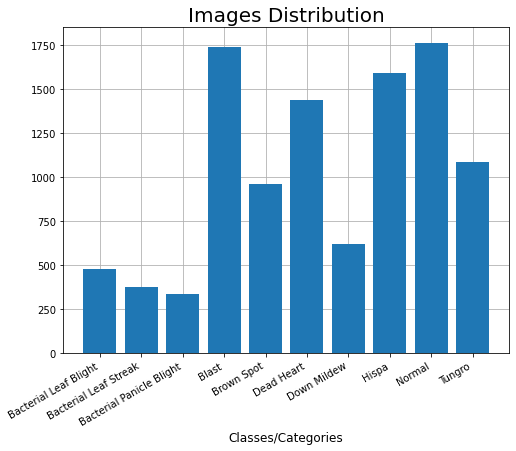

In [ ]:
# Execute simple_eda function
simple_eda(root_dir)


Label: Bacterial Leaf Blight


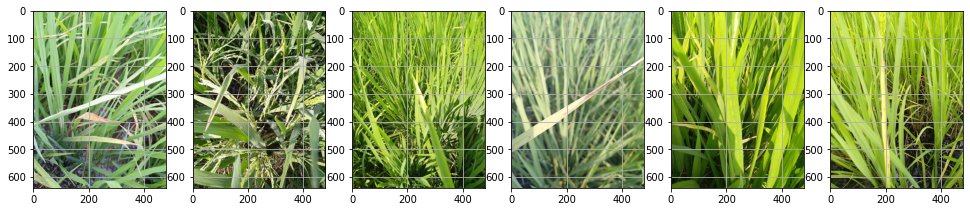


Label: Bacterial Leaf Streak


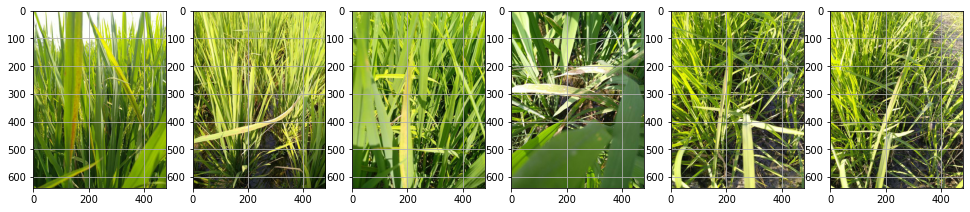


Label: Bacterial Panicle Blight


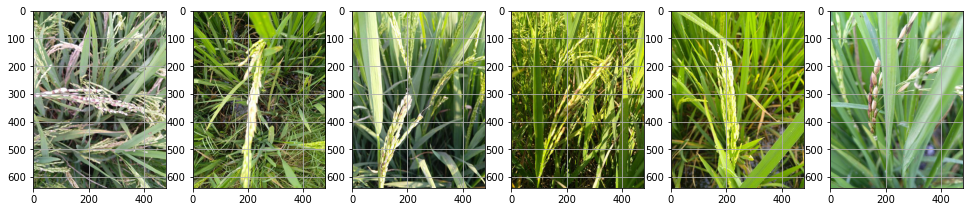


Label: Blast


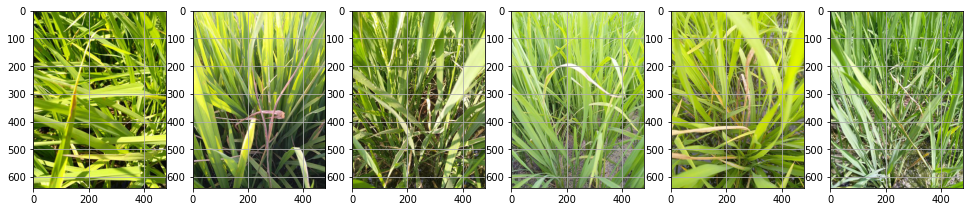


Label: Brown Spot


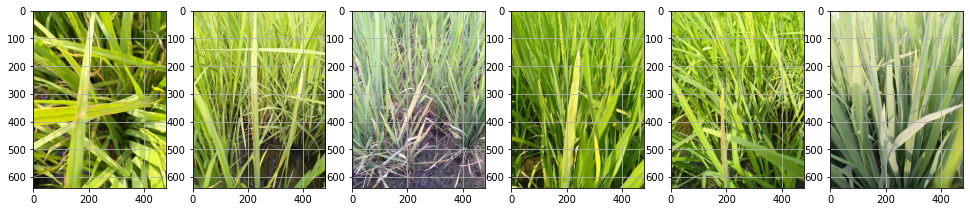


Label: Dead Heart


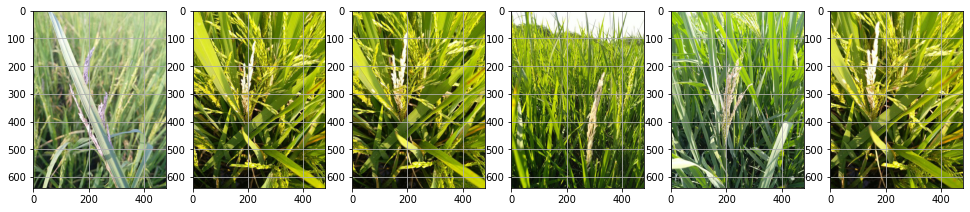


Label: Down Mildew


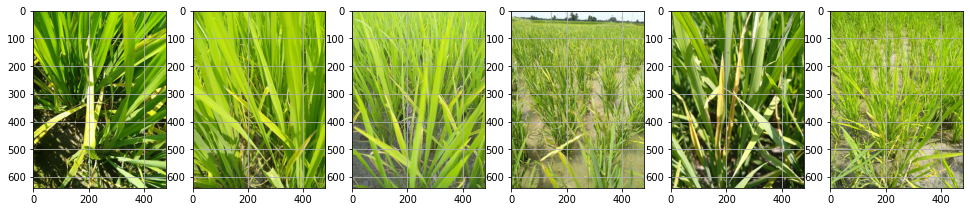


Label: Hispa


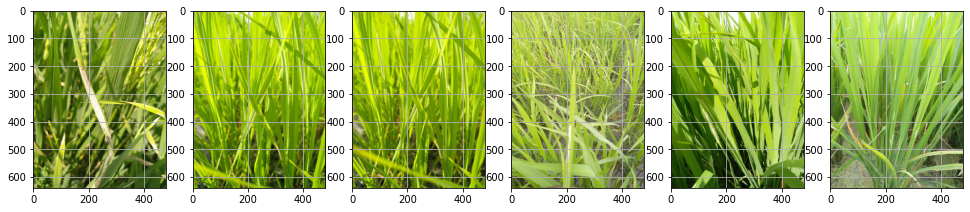


Label: Normal


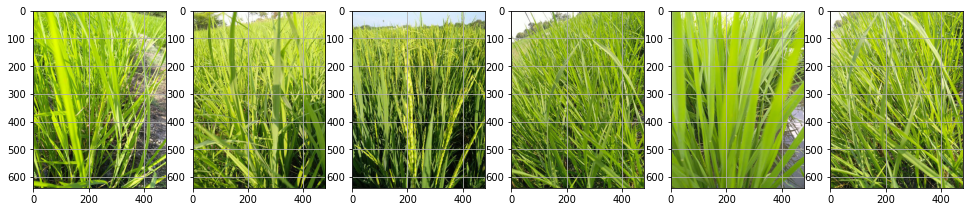


Label: Tungro


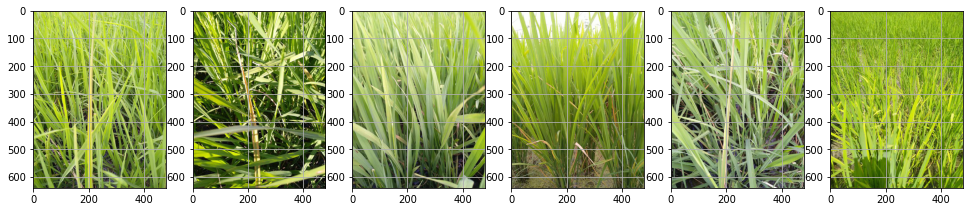

In [ ]:
# Execute display_sample function
display_sample(root_dir, num_sample=6)

# **Split Dataset**

In [ ]:
# Define a helper function to split data into training, validation, and testing
def split_class_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):
  """
  Params:
      SOURCE: Class source directory
      TRAINING: Destination directory for training split part 
      VALIDATION: Destination directory for validation split part
      TEST: Destination directory for test split part
      SPLIT_SIZE: Split size between train-validation and test
  """ 
  ## Make destination directories if not already exists
  for dir in [TRAINING, VALIDATION, TESTING]:
    if not os.path.exists(dir):
      os.makedirs(dir)

  ## Ensure passed split size is properly
  if SPLIT_SIZE > 1 or SPLIT_SIZE < 0:
    raise Exception('split size should be between 0 and 1')

  ## Copy images to destination
  train_val_len = int(len(os.listdir(SOURCE)) * SPLIT_SIZE)
  for index, file in enumerate(os.listdir(SOURCE)): 
    if index < train_val_len:
      ## Validation part is 5% from train-validation split size part
      if index < int(.95 * train_val_len): 
        shutil.copy(os.path.join(SOURCE, file), os.path.join(str(TRAINING)))
      else:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(str(VALIDATION)))
    else:
      shutil.copy(os.path.join(SOURCE, file), os.path.join(str(TESTING)))

# Define a function to display split distribution
def display_distribution(DIR, split_type=['Train', 'Validation', 'Test']):
  """
  Params:
         DIR: Root directory of destination directory that created for prior function
         split_type: Type of split         
  """ 
  ## Ensure that passed split type is properly
  user_input_type = [split_type]
  type_list = ['Train', 'Validation', 'Test']
  if len(user_input_type) > 1:
    raise Exception("Please choose one type of split")
  if user_input_type[0] not in type_list:
    raise Exception("Please choose a type of split that provided; \'Train\', \'Validation\', or \'Test\'")
  
  ## Display the distribution
  print("\n{}".format(user_input_type[0]))
  for dir_class in sorted(os.listdir(DIR)):
    print('{}: {} images'.format(dir_class, len(os.listdir(os.path.join(DIR, dir_class)))))

In [ ]:
# Create appropriate directories corresponds to Train, Validation, and Test split
## Set root directory of split data
root_split_dir = '/tmp/Split'

## Empty root directory to prevent FileExistsError when run several times
if os.path.exists(root_split_dir):
  shutil.rmtree(root_split_dir)

## Set each type of data split
train_split_dir = os.path.join(root_split_dir, 'Train')
validation_split_dir = os.path.join(root_split_dir, 'Validation')
test_split_dir = os.path.join(root_split_dir, 'Test')

## Set train directories each class
bacterial_leaf_blight_train_dir = os.path.join(train_split_dir, paddyleaf_classname[0])
bacterial_leaf_streak_train_dir = os.path.join(train_split_dir, paddyleaf_classname[1])
bacterial_panicle_blight_train_dir = os.path.join(train_split_dir, paddyleaf_classname[2])
blast_train_dir = os.path.join(train_split_dir, paddyleaf_classname[3])
brown_spot_train_dir = os.path.join(train_split_dir, paddyleaf_classname[4])
dead_heart_train_dir = os.path.join(train_split_dir, paddyleaf_classname[5])
downy_mildew_train_dir = os.path.join(train_split_dir, paddyleaf_classname[6])
hispa_train_dir = os.path.join(train_split_dir, paddyleaf_classname[7])
normal_train_dir = os.path.join(train_split_dir, paddyleaf_classname[8])
tungro_train_dir = os.path.join(train_split_dir, paddyleaf_classname[9])

## Set validation directories each class
bacterial_leaf_blight_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[0])
bacterial_leaf_streak_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[1])
bacterial_panicle_blight_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[2])
blast_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[3])
brown_spot_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[4])
dead_heart_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[5])
downy_mildew_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[6])
hispa_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[7])
normal_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[8])
tungro_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[9])

## Set test directories each class
bacterial_leaf_blight_test_dir = os.path.join(test_split_dir, paddyleaf_classname[0])
bacterial_leaf_streak_test_dir = os.path.join(test_split_dir, paddyleaf_classname[1])
bacterial_panicle_blight_test_dir = os.path.join(test_split_dir, paddyleaf_classname[2])
blast_test_dir = os.path.join(test_split_dir, paddyleaf_classname[3])
brown_spot_test_dir = os.path.join(test_split_dir, paddyleaf_classname[4])
dead_heart_test_dir = os.path.join(test_split_dir, paddyleaf_classname[5])
downy_mildew_test_dir = os.path.join(test_split_dir, paddyleaf_classname[6])
hispa_test_dir = os.path.join(test_split_dir, paddyleaf_classname[7])
normal_test_dir = os.path.join(test_split_dir, paddyleaf_classname[8])
tungro_test_dir = os.path.join(test_split_dir, paddyleaf_classname[9])

## Pass source directories each class before do split data
bacterial_leaf_blight_source_dir = os.path.join(root_dir, paddyleaf_classname[0])
bacterial_leaf_streak_source_dir = os.path.join(root_dir, paddyleaf_classname[1])
bacterial_panicle_blight_source_dir = os.path.join(root_dir, paddyleaf_classname[2])
blast_source_dir = os.path.join(root_dir, paddyleaf_classname[3])
brown_spot_source_dir = os.path.join(root_dir, paddyleaf_classname[4])
dead_heart_source_dir = os.path.join(root_dir, paddyleaf_classname[5])
downy_mildew_source_dir = os.path.join(root_dir, paddyleaf_classname[6])
hispa_source_dir = os.path.join(root_dir, paddyleaf_classname[7])
normal_source_dir = os.path.join(root_dir, paddyleaf_classname[8])
tungro_source_dir = os.path.join(root_dir, paddyleaf_classname[9])

## Define split size between training-validation and test set
split_size = .999

## Execute split_class_data function to split data into Train, Validation, and Test set for each class
split_class_data(bacterial_leaf_blight_source_dir, bacterial_leaf_blight_train_dir, bacterial_leaf_blight_validation_dir, bacterial_leaf_blight_test_dir, split_size)
split_class_data(bacterial_leaf_streak_source_dir, bacterial_leaf_streak_train_dir, bacterial_leaf_streak_validation_dir, bacterial_leaf_streak_test_dir, split_size)
split_class_data(bacterial_panicle_blight_source_dir, bacterial_panicle_blight_train_dir, bacterial_panicle_blight_validation_dir, bacterial_panicle_blight_test_dir, split_size)
split_class_data(blast_source_dir, blast_train_dir, blast_validation_dir, blast_test_dir, split_size)
split_class_data(brown_spot_source_dir, brown_spot_train_dir, brown_spot_validation_dir, brown_spot_test_dir, split_size)
split_class_data(dead_heart_source_dir, dead_heart_train_dir, dead_heart_validation_dir, dead_heart_test_dir, split_size)
split_class_data(downy_mildew_source_dir, downy_mildew_train_dir, downy_mildew_validation_dir, downy_mildew_test_dir, split_size)
split_class_data(hispa_source_dir, hispa_train_dir, hispa_validation_dir, hispa_test_dir, split_size)
split_class_data(normal_source_dir, normal_train_dir, normal_validation_dir, normal_test_dir, split_size)
split_class_data(tungro_source_dir, tungro_train_dir, tungro_validation_dir, tungro_test_dir, split_size)

## Execute display_distribution function
print('[Split Distribution]')
display_distribution(train_split_dir, split_type='Train')
display_distribution(validation_split_dir, split_type='Validation')
display_distribution(test_split_dir, split_type='Test')

[Split Distribution]

Train
Bacterial Leaf Blight: 454 images
Bacterial Leaf Streak: 360 images
Bacterial Panicle Blight: 319 images
Blast: 1649 images
Brown Spot: 915 images
Dead Heart: 1368 images
Down Mildew: 588 images
Hispa: 1512 images
Normal: 1673 images
Tungro: 1031 images

Validation
Bacterial Leaf Blight: 24 images
Bacterial Leaf Streak: 19 images
Bacterial Panicle Blight: 17 images
Blast: 87 images
Brown Spot: 49 images
Dead Heart: 72 images
Down Mildew: 31 images
Hispa: 80 images
Normal: 89 images
Tungro: 55 images

Test
Bacterial Leaf Blight: 1 images
Bacterial Leaf Streak: 1 images
Bacterial Panicle Blight: 1 images
Blast: 2 images
Brown Spot: 1 images
Dead Heart: 2 images
Down Mildew: 1 images
Hispa: 2 images
Normal: 2 images
Tungro: 2 images


# **Image Augmentation & Data Generator**

In [ ]:
def train_val_generator(TRAINING_DIR, VALIDATION_DIR, 
                         TARGET_SIZE, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE):
  """
  Params:
        TRAINING_DIR: Directory for training split that contains classes directory
        VALIDATION_DIR: Directory for validation split that contains classes directory
        TARGET_SIZE: Tuple contains target size height and width
        TRAIN_BATCH_SIZE: Desired train split batch size
        VAL_BATCH_SIZE: Desired validation split batch size
  Returns:
        train_genetator: Image data generator for train split
        validation_generator: Image data generator for validation split
  """ 
  ## Instantiate the ImageDataGenerator class with images augmentation
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=.2,
                                     height_shift_range=.2,
                                     shear_range=.2,
                                     zoom_range=.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  ## Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=TRAIN_BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=TARGET_SIZE)

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=VAL_BATCH_SIZE,
                                                                class_mode='categorical',
                                                                target_size=TARGET_SIZE)
  return train_generator, validation_generator

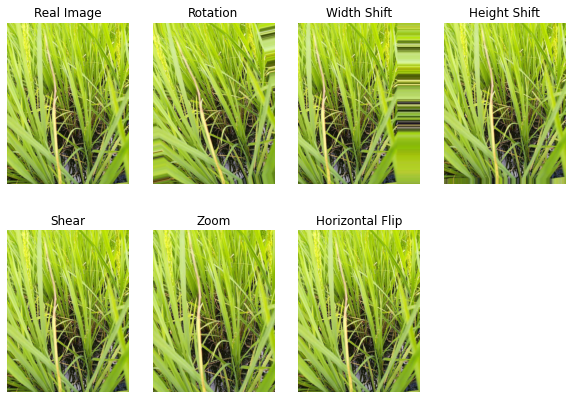

In [ ]:
# Function for display augmentation
def display_augmentation(IMG_PATH, ROTATION_RANGE, WIDTH_SHIFT_RANGE, 
                         HEIGHT_SHIFT_RANGE, SHEAR_RANGE, ZOOM_RANGE):
  """
  Params:
         IMG_PATH: Path to sample image
         **args: Parameters for augmentation 
  """ 
  ## Load image
  image = load_img(IMG_PATH)
  image_array = img_to_array(image)
  image_exp = np.expand_dims(image_array, 0)

  ## Rotation parameter
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=ROTATION_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_rotate = batch[0]

  ## Width shift parameter
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=WIDTH_SHIFT_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_width_shift = batch[0]

  ## Height shift parameter
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     height_shift_range=HEIGHT_SHIFT_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_height_shift = batch[0]

  ## Shear parameter
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     shear_range=SHEAR_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_shear = batch[0]

  ## Zoom parameter
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=ZOOM_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_zoom = batch[0]

  ## Horizontal flip parameter
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     horizontal_flip=True)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_horizontal_flip = batch[0]

  ## Display with pyplot
  fig = plt.figure(figsize=(10, 7))
  rows = 2
  cols = 4
  augmented_images = [0, image, image_rotate, image_width_shift, image_height_shift, image_shear, image_zoom, image_horizontal_flip]
  plt_title = [0, "Real Image", "Rotation", "Width Shift", "Height Shift", "Shear", "Zoom", "Horizontal Flip"]
  for index in range(len(augmented_images)):
    if index == 0:
      continue
    fig.add_subplot(rows, cols, index)
    plt.imshow(augmented_images[index])
    plt.axis('off')
    plt.title(plt_title[index])

# Get a random image from one particular class
random_image = random.choice(os.listdir(bacterial_leaf_blight_train_dir))
rotation_range = 60
width_shift_range = .2
height_shift_range = .2
shear_range = .2
zoom_range = .2
display_augmentation(os.path.join(bacterial_leaf_blight_train_dir, random_image),
                     rotation_range,
                     width_shift_range,
                     height_shift_range,
                     shear_range,
                     zoom_range)

In [ ]:
# Set batch size and target image size
train_batch_size = 256
val_batch_size = 128
target_size = (150, 150)

# Get train and validation data generator
train_generator, validation_generator = train_val_generator(train_split_dir,
                                                            validation_split_dir,
                                                            target_size,
                                                            train_batch_size,
                                                            val_batch_size)

Found 9869 images belonging to 10 classes.
Found 523 images belonging to 10 classes.


In [ ]:
## Display classes index
print("Train Generator code for each class \n{}".format(train_generator.class_indices))
print("\n Validation Generator code for each class \n{}".format(validation_generator.class_indices))

Train Generator code for each class 
{'Bacterial Leaf Blight': 0, 'Bacterial Leaf Streak': 1, 'Bacterial Panicle Blight': 2, 'Blast': 3, 'Brown Spot': 4, 'Dead Heart': 5, 'Down Mildew': 6, 'Hispa': 7, 'Normal': 8, 'Tungro': 9}

 Validation Generator code for each class 
{'Bacterial Leaf Blight': 0, 'Bacterial Leaf Streak': 1, 'Bacterial Panicle Blight': 2, 'Blast': 3, 'Brown Spot': 4, 'Dead Heart': 5, 'Down Mildew': 6, 'Hispa': 7, 'Normal': 8, 'Tungro': 9}


# **Model v1.1**

## **Model Architecture**

In [ ]:
# Create a simple CNN architecture
def create_model(TARGET_SIZE):
  """
  Params:
        TARGET_SIZE: Tuple contains target size height and width   
  Returns:
        model: Created model
  """ 
  ## Construct model architecture
  ### Set with Sequential 
  model = tf.keras.models.Sequential([ 
      ### The first convolution and maxpool                                  
      tf.keras.layers.Conv2D(32, (3,3), activation='relu',
                             input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      ### The second convolution and maxpool                                  
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      ### The third convolution and maxpool                                  
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      ### The fourth convolution and maxpool                                  
      tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      ### Flatten convolution part result
      tf.keras.layers.Flatten(),
      ### The first dense layer
      tf.keras.layers.Dense(1024, activation='relu'),
      ### The second dense layer
      tf.keras.layers.Dense(512, activation='relu'),
      ### The output layer
      tf.keras.layers.Dense(10, activation='softmax', name="predict_class")
  ])

  ## Compile model with its optimizer, loss, and metrics  
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 

  ## Return the created model  
  return model

In [ ]:
# Get the model architecture by pass target_size defined before
modelv1d1 = create_model(target_size)

# Get model summary
modelv1d1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## **Train the Model**

In [ ]:
# Callbacks schedule
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check
    if logs.get('accuracy') > .99 and logs.get('val_accuracy') > .95:

      # Stop if threshold is met
      print("\nThe thresholds are met so stop training!")
      self.model.stop_training = True

    # Get learning rate callbacks
    #lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Instantiate class
callbacks = myCallback()

# Create simple early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


# Model checkpoint
model_checkp = tf.keras.callbacks.ModelCheckpoint('model_v1d1_checkp.h5', monitor='val_accuracy',
                                                  mode='max', verbose=1, save_best_only=True)

In [ ]:
# Train the model
history = modelv1d1.fit(train_generator,
                         epochs=50,
                         steps_per_epoch=int(train_generator.samples/train_batch_size),
                         verbose=1,
                         validation_data=validation_generator,
                         validation_steps=int(validation_generator.samples/val_batch_size),
                         callbacks=[callbacks, early_stop, model_checkp])

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 2.1885 - accuracy: 0.1870
Epoch 1: val_accuracy improved from -inf to 0.22656, saving model to model_v1d1_checkp.h5
38/38 [==============================] - 107s 2s/step - loss: 2.1885 - accuracy: 0.1870 - val_loss: 2.0826 - val_accuracy: 0.2266
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 2.0035 - accuracy: 0.2831
Epoch 2: val_accuracy improved from 0.22656 to 0.34570, saving model to model_v1d1_checkp.h5
38/38 [==============================] - 94s 2s/step - loss: 2.0035 - accuracy: 0.2831 - val_loss: 1.9051 - val_accuracy: 0.3457
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 1.8849 - accuracy: 0.3275
Epoch 3: val_accuracy improved from 0.34570 to 0.40820, saving model to model_v1d1_checkp.h5
38/38 [==============================] - 94s 2s/step - loss: 1.8849 - accuracy: 0.3275 - val_loss: 1.7181 - val_accuracy: 0.4082
Epoch 4/50
38/38 [==============================] - ET

## **Result Plot**

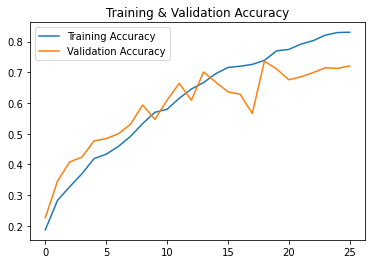

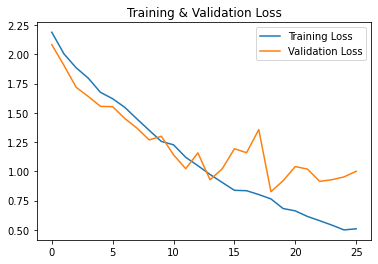

In [ ]:
# Plot the train result
## Get accuracy and val_accuracy histories
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

## Get accuracy and val_accuracy losses
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

## Plot accuracies result
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')

plt.legend()
plt.show() 

plt.figure()

## Plot losses result
plt.plot(epochs, loss, label ='Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title('Training & Validation Loss')

plt.legend()
plt.show()  

In [ ]:
train_score = modelv1d1.evaluate(train_generator)
validation_score = modelv1d1.evaluate(validation_generator)

print('Overall Train Accuracy : ', train_score[1])
print('Overall Validation Accuracy: ', validation_score[1])

5/5 [==============================] - 3s 521ms/step - loss: 0.9942 - accuracy: 0.7189
Overall Train Accuracy :  0.8462863564491272
Overall Validation Accuracy:  0.7189292311668396


## **Image Predict**

Actual class: Bacterial Leaf Streak
Predicted class: Hispa
 with the probabilities for each class as follow 
[2.9283951e-03 4.9530216e-02 1.2017158e-05 9.5943892e-03 3.8838667e-01
 5.9656624e-04 7.1030678e-03 5.0900090e-01 1.8484055e-04 3.2662846e-02]


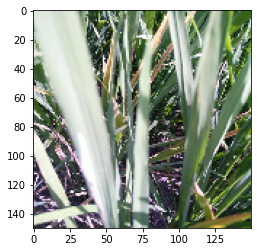

In [ ]:
# Test image preprocess
random_class = os.path.join(test_split_dir, random.choice(paddyleaf_classname))
random_image = random.choice(os.listdir(random_class))
selected_image = load_img(os.path.join(random_class, random_image), target_size=target_size)
x = img_to_array(selected_image)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.

# Predict the image
classes = modelv1d1.predict(x)
predicted_class = np.argmax(classes[0])

# Display the image and its predicted class
imageplot = plt.imshow(selected_image)
print("Actual class: {}".format(random_class.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(paddyleaf_classname[predicted_class], classes[0]))

Actual class: Dead Heart
Predicted class: Dead Heart
 with the probabilities for each class as follow 
[4.3506560e-14 3.3307745e-13 6.9005896e-06 1.9023387e-08 1.1116906e-14
 9.9999309e-01 6.1252168e-09 5.6554669e-19 7.0705058e-10 2.7546619e-08]


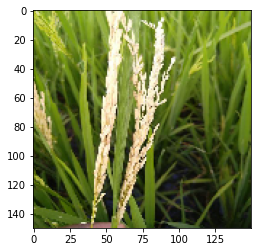

In [ ]:
# Test image preprocess
random_class = os.path.join(test_split_dir, random.choice(paddyleaf_classname))
random_image = random.choice(os.listdir(random_class))
selected_image = load_img(os.path.join(random_class, random_image), target_size=target_size)
x = img_to_array(selected_image)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.

# Predict the image
classes = modelv1d1.predict(x)
predicted_class = np.argmax(classes[0])

# Display the image and its predicted class
imageplot = plt.imshow(selected_image)
print("Actual class: {}".format(random_class.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(paddyleaf_classname[predicted_class], classes[0]))

## **Save & Export Model**

In [ ]:
# Save the model
## Define temporary directory for save the model
MODEL_DIR = tempfile.gettempdir()
version = 1
diff = 1
version_path = os.path.join(MODEL_DIR, str(version))
export_path = os.path.join(version_path, str(diff))

## Ensure the temporary file
if os.path.isdir(export_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_path}

## Save the model
### tf format
modelv1d1.save(export_path, save_format="tf")
print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

### h5 keras format
saved_h5_format = './paddymodelv1d1.h5' 
modelv1d1.save(saved_h5_format)

INFO:tensorflow:Assets written to: /tmp/1/1/assets

export_path = /tmp/1/1
total 232
drwxr-xr-x 2 root root   4096 Jun  1 11:06 assets
-rw-r--r-- 1 root root  24965 Jun  1 11:06 keras_metadata.pb
-rw-r--r-- 1 root root 199340 Jun  1 11:06 saved_model.pb
drwxr-xr-x 2 root root   4096 Jun  1 11:06 variables


In [ ]:
# Convert to .json format
## Install required library
!pip install tensorflowjs

## Path to .json directory
export_json_path = os.path.join(export_path, 'json_format')

## Ensure the temporary file
if os.path.isdir(export_json_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_json_path}

## Convert command
!tensorflowjs_converter --input_format=keras {saved_h5_format} {export_json_path}

##
!zip -r './jsonmodelv1d1.zip' {export_json_path}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.5 MB/s 
     |████████████████████████████████| 40 kB 4.6 MB/s 
     |████████████████████████████████| 462 kB 16.2 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


  adding: tmp/1/1/json_format/ (stored 0%)
  adding: tmp/1/1/json_format/group1-shard3of14.bin (deflated 8%)
  adding: tmp/1/1/json_format/group1-shard12of14.bin (deflated 7%)
  adding: tmp/1/1/json_format/group1-shard11of14.bin (deflated 7%)
  adding: tmp/1/1/json_format/group1-shard8of14.bin (deflated 7%)
  adding: tmp/1/1/json_format/group1-shard2of14.bin (deflated 7%)
  adding: tmp/1/1/json_format/group1-shard10of14.bin (deflated 7%)
  adding: tmp/1/1/json_format/group1-shard13of14.bin (deflated 7%)
  adding: tmp/1/1/json_format/group1-shard1of14.bin (deflated 7%)
  adding: tmp/1/1/json_format/group1-shard4of14.bin (deflated 8%)
  adding: tmp/1/1/json_format/group1-shard6of14.bin (deflated 8%)
  adding: tmp/1/1/json_format/group1-shard7of14.bin (deflated 8%)
  adding: tmp/1/1/json_format/model.json (deflated 85%)
  adding: tmp/1/1/json_format/group1-shard5of14.bin (deflated 8%)
  adding: tmp/1/1/json_format/group1-shard9of14.bin (deflated 7%)
  adding: tmp/1/1/json_format/group1-sh

In [ ]:
# Convert to .tflite format
## Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

## Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

## Use the tool to finally convert the model
tflite_model = converter.convert()

## Write TFLite model and its classes
tflite_model_file = 'paddymodel_v1_d1.tflite'

with open(tflite_model_file, "wb") as tf:
    tf.write(tflite_model)

with open('paddyclasses_v1_d1.txt', 'w') as classes:
    classes.write('\n'.join(paddyleaf_classname))

In [ ]:
try:
    files.download('paddymodel_v1_d1.tflite')
    files.download('paddyclasses_v1_d1.txt')
    files.download('jsonmodelv1d1.zip')
    
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Model v1.2 - Transfer Learning: InceptionV3**

## **Model Architecture**

In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-11 12:27:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  34.7MB/s    in 2.4s    

2022-06-11 12:27:16 (34.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Get the pre-trained model
def create_pre_trained_model(WEIGHTS, TARGET_SIZE):
  """
  Params:
        WEIGHTS: Choosen weights from pre trained model
        TARGET_SIZE: Tuple contains target size height and width   
  Returns:
        pre_trained_model: Imported pre trained model
  """ 
  ## Import InceptionV3 Model
  pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
      input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3),
      include_top = False, 
      weights = None)

  pre_trained_model.load_weights(WEIGHTS)
  
  return pre_trained_model

In [ ]:
# Execute create_pre_trained_model function
## Use downloaded weights
pre_trained_model = create_pre_trained_model('/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                             target_size)

## Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [ ]:
# Create a function to pipeline imported model
## Set the desired layer from pre-trained model as a input for self-model
def output_of_last_layer(PRE_TRAINED_MODEL):
  """
  Params:
        PRE_TRAINED_MODEL: Imported pre trained model  
  Returns:
        last_output: The desired layer as a input for self-model
  """ 
  last_desired_layer = PRE_TRAINED_MODEL.get_layer('mixed7')
  last_output = last_desired_layer.output

  return last_output

In [ ]:
# Execute the prior function
last_output = output_of_last_layer(pre_trained_model)

In [ ]:
# Create Final Model
def create_model(PRE_TRAINED_MODEL, LAST_OUTPUT):
  """
  Params:
        PRE_TRAINED_MODEL: Imported pre trained model 
        LAST_OUTPUT: The desired layer as a input for self-model  
  Returns:
        model: Created model
  """ 
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(LAST_OUTPUT)
  # Add a fully connected layer with hidden units and ReLU activation
  x = tf.keras.layers.Dense(2048, activation='relu')(x)
  # Add a dropout rate
  x = tf.keras.layers.Dropout(.3)(x)
  # Add another hidden layer
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  # Add a output layer for classification
  x = tf.keras.layers.Dense(10, activation='softmax', name="predict_class")(x) 

  # Create the complete model by using the Model class
  model = tf.keras.Model(inputs=PRE_TRAINED_MODEL.input, outputs=x)

  # Fine Tuning
  NUM_LAYERS = 20 #@param {type:"slider", min:1, max:50, step:1}
  do_fine_tuning = False #@param {type:"boolean"}

  if do_fine_tuning:
      optimizer = tf.keras.optimizers.SGD(lr=5e-3, momentum=0.9)
    
      for layer in model.layers[-NUM_LAYERS:]:
          layer.trainable = True

      # Make all the layers in the pre-trained model trainable
      for layer in pre_trained_model.layers:
          layer.trainable = True
  else:
      optimizer = 'adam'

      # Make all the layers in the pre-trained model non-trainable
      for layer in pre_trained_model.layers:
          layer.trainable = False

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  return model

In [ ]:
# Get the model architecture by pass target_size defined before
modelv1d2 = create_model(pre_trained_model, last_output)

# Get model summary
modelv1d2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                              

## **Train the Model**

In [ ]:
# Callbacks schedule
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check
    if logs.get('accuracy') > .99 and logs.get('val_accuracy') > .95:

      # Stop if threshold is met
      print("\nThe thresholds are met so stop training!")
      self.model.stop_training = True

    # Get learning rate callbacks
    #lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Instantiate class
callbacks = myCallback()

# Create simple early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


# Model checkpoint
model_checkp = tf.keras.callbacks.ModelCheckpoint('model_v1d2_checkp.h5', monitor='val_accuracy',
                                                  mode='max', verbose=1, save_best_only=True)

In [ ]:
# Train the model
history = modelv1d2.fit(train_generator,
                         epochs=50,
                         steps_per_epoch=int(train_generator.samples/train_batch_size),
                         verbose=1,
                         validation_data=validation_generator,
                         validation_steps=int(validation_generator.samples/val_batch_size),
                         callbacks=[callbacks, early_stop, model_checkp])

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 4.1664 - accuracy: 0.2217
Epoch 1: val_accuracy improved from -inf to 0.35742, saving model to model_v1d2_checkp.h5
38/38 [==============================] - 113s 3s/step - loss: 4.1664 - accuracy: 0.2217 - val_loss: 1.8960 - val_accuracy: 0.3574
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 1.7810 - accuracy: 0.3946
Epoch 2: val_accuracy improved from 0.35742 to 0.50977, saving model to model_v1d2_checkp.h5
38/38 [==============================] - 98s 3s/step - loss: 1.7810 - accuracy: 0.3946 - val_loss: 1.4684 - val_accuracy: 0.5098
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 1.5437 - accuracy: 0.4722
Epoch 3: val_accuracy improved from 0.50977 to 0.52734, saving model to model_v1d2_checkp.h5
38/38 [==============================] - 95s 3s/step - loss: 1.5437 - accuracy: 0.4722 - val_loss: 1.3505 - val_accuracy: 0.5273
Epoch 4/50
38/38 [==============================] - ET

## **Result Plot**

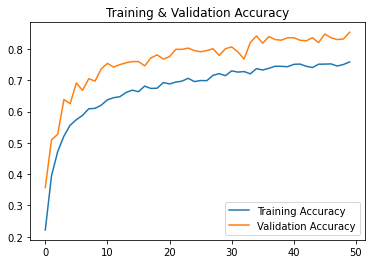

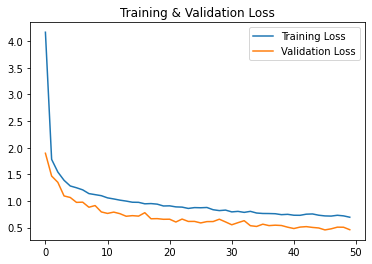

In [ ]:
# Plot the train result
## Get accuracy and val_accuracy histories
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

## Get accuracy and val_accuracy losses
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

## Plot accuracies result
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')

plt.legend()
plt.show() 

plt.figure()

## Plot losses result
plt.plot(epochs, loss, label ='Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title('Training & Validation Loss')

plt.legend()
plt.show()  

In [ ]:
train_score = modelv1d2.evaluate(train_generator)
validation_score = modelv1d2.evaluate(validation_generator)

print('Overall Train Accuracy : ', train_score[1])
print('Overall Validation Accuracy: ', validation_score[1])

5/5 [==============================] - 3s 657ms/step - loss: 0.4679 - accuracy: 0.8509
Overall Train Accuracy :  0.8234876990318298
Overall Validation Accuracy:  0.8508604168891907


## **Image Predict**

Actual class: Down Mildew
Predicted class: Down Mildew
 with the probabilities for each class as follow 
[2.2815463e-08 1.3908851e-08 3.1144972e-12 4.9130863e-06 4.8281476e-07
 1.0719389e-08 9.9999213e-01 5.7312359e-08 4.6305301e-10 2.3793732e-06]


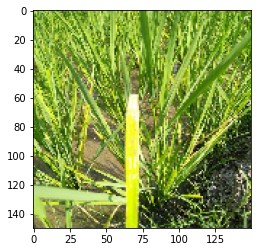

In [ ]:
# Test image preprocess
random_class = os.path.join(test_split_dir, random.choice(paddyleaf_classname))
random_image = random.choice(os.listdir(random_class))
selected_image = load_img(os.path.join(random_class, random_image), target_size=target_size)
x = img_to_array(selected_image)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.

# Predict the image
classes = modelv1d2.predict(x)
predicted_class = np.argmax(classes[0])

# Display the image and its predicted class
imageplot = plt.imshow(selected_image)
print("Actual class: {}".format(random_class.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(paddyleaf_classname[predicted_class], classes[0]))

Actual class: Hispa
Predicted class: Hispa
 with the probabilities for each class as follow 
[3.9993486e-04 4.0479391e-04 1.4521380e-05 3.0660986e-03 3.7528612e-03
 1.7329793e-04 2.0660264e-03 9.6851188e-01 1.9324506e-02 2.2860619e-03]


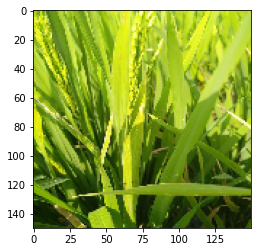

In [ ]:
# Test image preprocess
random_class = os.path.join(test_split_dir, random.choice(paddyleaf_classname))
random_image = random.choice(os.listdir(random_class))
selected_image = load_img(os.path.join(random_class, random_image), target_size=target_size)
x = img_to_array(selected_image)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.

# Predict the image
classes = modelv1d2.predict(x)
predicted_class = np.argmax(classes[0])

# Display the image and its predicted class
imageplot = plt.imshow(selected_image)
print("Actual class: {}".format(random_class.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(paddyleaf_classname[predicted_class], classes[0]))

## **Save & Export Model**

In [ ]:
# Save the model
## Define temporary directory for save the model
MODEL_DIR = tempfile.gettempdir()
version = 1
diff = 2
version_path = os.path.join(MODEL_DIR, str(version))
export_path = os.path.join(version_path, str(diff))

## Ensure the temporary file
if os.path.isdir(export_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_path}

## Save the model
### tf format
modelv1d2.save(export_path, save_format="tf")
print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

### h5 keras format
saved_h5_format = './paddymodelv1d2.h5' 
modelv1d2.save(saved_h5_format)

INFO:tensorflow:Assets written to: /tmp/1/2/assets

export_path = /tmp/1/2
total 3764
drwxr-xr-x 2 root root    4096 Jun 11 14:16 assets
-rw-r--r-- 1 root root  485453 Jun 11 14:16 keras_metadata.pb
-rw-r--r-- 1 root root 3355627 Jun 11 14:16 saved_model.pb
drwxr-xr-x 2 root root    4096 Jun 11 14:16 variables


In [ ]:
# Convert to .json format
## Install required library
!pip install tensorflowjs

## Path to .json directory
export_json_path = os.path.join(export_path, 'json_format')

## Ensure the temporary file
if os.path.isdir(export_json_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_json_path}

## Convert command
!tensorflowjs_converter --input_format=keras {saved_h5_format} {export_json_path}

##
!zip -r './jsonmodelv1d2.zip' {export_json_path}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 40 kB 7.3 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


  adding: tmp/1/2/json_format/ (stored 0%)
  adding: tmp/1/2/json_format/group1-shard30of85.bin (deflated 7%)
  adding: tmp/1/2/json_format/group1-shard57of85.bin (deflated 7%)
  adding: tmp/1/2/json_format/group1-shard71of85.bin (deflated 7%)
  adding: tmp/1/2/json_format/group1-shard5of85.bin (deflated 7%)
  adding: tmp/1/2/json_format/group1-shard17of85.bin (deflated 8%)
  adding: tmp/1/2/json_format/group1-shard70of85.bin (deflated 8%)
  adding: tmp/1/2/json_format/group1-shard44of85.bin (deflated 7%)
  adding: tmp/1/2/json_format/group1-shard29of85.bin (deflated 7%)
  adding: tmp/1/2/json_format/group1-shard84of85.bin (deflated 8%)
  adding: tmp/1/2/json_format/group1-shard20of85.bin (deflated 7%)
  adding: tmp/1/2/json_format/group1-shard52of85.bin (deflated 7%)
  adding: tmp/1/2/json_format/group1-shard38of85.bin (deflated 8%)
  adding: tmp/1/2/json_format/group1-shard7of85.bin (deflated 7%)
  adding: tmp/1/2/json_format/group1-shard83of85.bin (deflated 8%)
  adding: tmp/1/2/jso

In [ ]:
# Convert to .tflite format
## Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

## Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

## Use the tool to finally convert the model
tflite_model = converter.convert()

## Write TFLite model and its classes
tflite_model_file = 'paddymodel_v1_d2.tflite'

with open(tflite_model_file, "wb") as tf:
    tf.write(tflite_model)

with open('paddyclasses_v1_d2.txt', 'w') as classes:
    classes.write('\n'.join(paddyleaf_classname))

In [ ]:
try:
    files.download('paddymodel_v1_d2.tflite')
    files.download('paddyclasses_v1_d2.txt')
    files.download('jsonmodelv1d2.zip')
    
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Model v1.3 - Transfer Learning: Fine-Tuning InceptionV3**

## **Model Architecture**

In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-07 03:30:36--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 142.250.188.208, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  66.2MB/s    in 1.3s    

2022-06-07 03:30:37 (66.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Get the pre-trained model
def create_pre_trained_model(WEIGHTS, TARGET_SIZE):
  """
  Params:
        WEIGHTS: Choosen weights from pre trained model
        TARGET_SIZE: Tuple contains target size height and width   
  Returns:
        pre_trained_model: Imported pre trained model
  """ 
  ## Import InceptionV3 Model
  pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
      input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3),
      include_top = False, 
      weights = None)

  pre_trained_model.load_weights(WEIGHTS)
  
  return pre_trained_model

In [ ]:
# Execute create_pre_trained_model function
## Use downloaded weights
pre_trained_model = create_pre_trained_model('/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                             target_size)

## Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# Create a function to pipeline imported model
## Set the desired layer from pre-trained model as a input for self-model
def output_of_last_layer(PRE_TRAINED_MODEL):
  """
  Params:
        PRE_TRAINED_MODEL: Imported pre trained model  
  Returns:
        last_output: The desired layer as a input for self-model
  """ 
  last_desired_layer = PRE_TRAINED_MODEL.get_layer('mixed7')
  last_output = last_desired_layer.output

  return last_output

In [ ]:
# Execute the prior function
last_output = output_of_last_layer(pre_trained_model)

In [ ]:
# Create Final Model
def create_model(PRE_TRAINED_MODEL, LAST_OUTPUT):
  """
  Params:
        PRE_TRAINED_MODEL: Imported pre trained model 
        LAST_OUTPUT: The desired layer as a input for self-model  
  Returns:
        model: Created model
  """ 
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(LAST_OUTPUT)
  # Add a fully connected layer with hidden units and ReLU activation
  x = tf.keras.layers.Dense(2048, activation='relu')(x)
  # Add a dropout rate
  x = tf.keras.layers.Dropout(.3)(x)
  # Add another hidden layer
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  # Add a output layer for classification
  x = tf.keras.layers.Dense(10, activation='softmax', name="predict_class")(x) 

  # Create the complete model by using the Model class
  model = tf.keras.Model(inputs=PRE_TRAINED_MODEL.input, outputs=x)

  # Fine Tuning
  NUM_LAYERS = 20 #@param {type:"slider", min:1, max:50, step:1}
  do_fine_tuning = True #@param {type:"boolean"}

  if do_fine_tuning:
      optimizer = tf.keras.optimizers.SGD(lr=5e-3, momentum=0.9)
    
      for layer in model.layers[-NUM_LAYERS:]:
          layer.trainable = True

      # Make all the layers in the pre-trained model trainable
      for layer in pre_trained_model.layers:
          layer.trainable = True
  else:
      optimizer = 'adam'

      # Make all the layers in the pre-trained model non-trainable
      for layer in pre_trained_model.layers:
          layer.trainable = False

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  return model

In [ ]:
# Get the model architecture by pass target_size defined before
modelv1d3 = create_model(pre_trained_model, last_output)

# Get model summary
modelv1d3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activation_10 (Activation)     (None, 16, 16, 96)   0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 activation_11 (Activation)     (None, 16, 16, 32)   0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 mixed0 (Concatenate)           (None, 16, 16, 256)  0           ['activation_5[0][0]',           
                                                                  'activation_7[0][0]',           
                                                                  'activation_10[0][0]',          
                                                                  'activation_11[0][0]']          
          

## **Train the Model**

In [ ]:
# Callbacks schedule
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check
    if logs.get('accuracy') > .99 and logs.get('val_accuracy') > .95:

      # Stop if threshold is met
      print("\nThe thresholds are met so stop training!")
      self.model.stop_training = True

    # Get learning rate callbacks
    #lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Instantiate class
callbacks = myCallback()

# Create simple early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


# Model checkpoint
model_checkp = tf.keras.callbacks.ModelCheckpoint('model_v1d3_checkp.h5', monitor='val_accuracy',
                                                  mode='max', verbose=1, save_best_only=True)

In [ ]:
# Train the model
history = modelv1d3.fit(train_generator,
                         epochs=50,
                         steps_per_epoch=int(train_generator.samples/train_batch_size),
                         verbose=1,
                         validation_data=validation_generator,
                         validation_steps=int(validation_generator.samples/val_batch_size),
                         callbacks=[callbacks, early_stop, model_checkp])

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 2.0830 - accuracy: 0.2528
Epoch 1: val_accuracy improved from -inf to 0.36523, saving model to model_v1d3_checkp.h5
38/38 [==============================] - 123s 3s/step - loss: 2.0830 - accuracy: 0.2528 - val_loss: 1.8843 - val_accuracy: 0.3652
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 1.6677 - accuracy: 0.4393
Epoch 2: val_accuracy did not improve from 0.36523
38/38 [==============================] - 98s 3s/step - loss: 1.6677 - accuracy: 0.4393 - val_loss: 2.0925 - val_accuracy: 0.3613
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 1.1993 - accuracy: 0.5951
Epoch 3: val_accuracy improved from 0.36523 to 0.55664, saving model to model_v1d3_checkp.h5
38/38 [==============================] - 100s 3s/step - loss: 1.1993 - accuracy: 0.5951 - val_loss: 1.3292 - val_accuracy: 0.5566
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 0.9153 - accuracy: 0.6888
E

## **Result Plot**

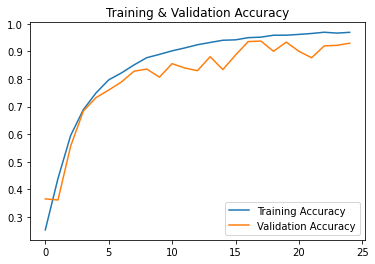

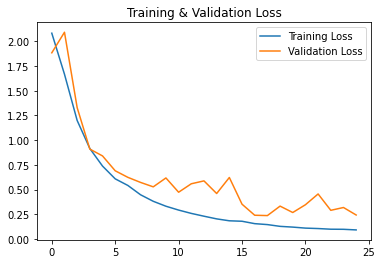

In [ ]:
# Plot the train result
## Get accuracy and val_accuracy histories
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

## Get accuracy and val_accuracy losses
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

## Plot accuracies result
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')

plt.legend()
plt.show() 

plt.figure()

## Plot losses result
plt.plot(epochs, loss, label ='Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title('Training & Validation Loss')

plt.legend()
plt.show()  

## **Overall Accuracy Model**

In [ ]:
train_score = modelv1d3.evaluate(train_generator)
validation_score = modelv1d3.evaluate(validation_generator)

print('Overall Train Accuracy : ', train_score[1])
print('Overall Validation Accuracy: ', validation_score[1])

5/5 [==============================] - 3s 607ms/step - loss: 0.2384 - accuracy: 0.9312
Overall Train Accuracy :  0.9572398662567139
Overall Validation Accuracy:  0.9311663508415222


## **Image Predict**

Actual class: Dead Heart
Predicted class: Dead Heart
 with the probabilities for each class as follow 
[1.00948537e-05 1.45982915e-08 9.95326409e-05 6.85365791e-08
 1.59950293e-08 9.95707214e-01 2.39130077e-06 2.14665852e-05
 4.01658006e-03 1.42644494e-04]


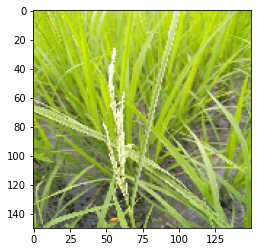

In [ ]:
# Test image preprocess
random_class = os.path.join(test_split_dir, random.choice(paddyleaf_classname))
random_image = random.choice(os.listdir(random_class))
selected_image = load_img(os.path.join(random_class, random_image), target_size=target_size)
x = img_to_array(selected_image)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.

# Predict the image
classes = modelv1d3.predict(x)
predicted_class = np.argmax(classes[0])

# Display the image and its predicted class
imageplot = plt.imshow(selected_image)
print("Actual class: {}".format(random_class.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(paddyleaf_classname[predicted_class], classes[0]))

Actual class: Bacterial Panicle Blight
Predicted class: Bacterial Panicle Blight
 with the probabilities for each class as follow 
[3.5085133e-09 1.0093172e-09 9.9937588e-01 9.3229062e-08 9.6401787e-10
 5.3842016e-04 7.3667277e-09 6.7740804e-09 8.5479507e-05 6.7324750e-09]


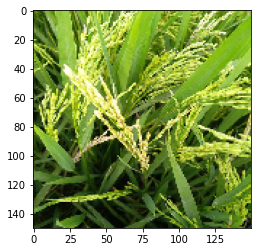

In [ ]:
# Test image preprocess
random_class = os.path.join(test_split_dir, random.choice(paddyleaf_classname))
random_image = random.choice(os.listdir(random_class))
selected_image = load_img(os.path.join(random_class, random_image), target_size=target_size)
x = img_to_array(selected_image)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.

# Predict the image
classes = modelv1d3.predict(x)
predicted_class = np.argmax(classes[0])

# Display the image and its predicted class
imageplot = plt.imshow(selected_image)
print("Actual class: {}".format(random_class.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(paddyleaf_classname[predicted_class], classes[0]))

## **Save & Export Model**

In [ ]:
# Save the model
## Define temporary directory for save the model
MODEL_DIR = tempfile.gettempdir()
version = 1
diff = 3
version_path = os.path.join(MODEL_DIR, str(version))
export_path = os.path.join(version_path, str(diff))

## Ensure the temporary file
if os.path.isdir(export_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_path}

## Save the model
### tf format
modelv1d3.save(export_path, save_format="tf")
print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

### h5 keras format
saved_h5_format = './paddymodelv1d3.h5' 
modelv1d3.save(saved_h5_format)

INFO:tensorflow:Assets written to: /tmp/1/3/assets

export_path = /tmp/1/3
total 4068
drwxr-xr-x 2 root root    4096 Jun  7 04:33 assets
-rw-r--r-- 1 root root  482351 Jun  7 04:33 keras_metadata.pb
-rw-r--r-- 1 root root 3670105 Jun  7 04:33 saved_model.pb
drwxr-xr-x 2 root root    4096 Jun  7 04:33 variables


In [ ]:
# Convert to .json format
## Install required library
!pip install tensorflowjs

## Path to .json directory
export_json_path = os.path.join(export_path, 'json_format')

## Ensure the temporary file
if os.path.isdir(export_json_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_json_path}

## Convert command
!tensorflowjs_converter --input_format=keras {saved_h5_format} {export_json_path}

##
!zip -r './jsonmodelv1d3.zip' {export_json_path}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 40 kB 8.0 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


  adding: tmp/1/3/json_format/ (stored 0%)
  adding: tmp/1/3/json_format/group1-shard79of85.bin (deflated 8%)
  adding: tmp/1/3/json_format/group1-shard7of85.bin (deflated 7%)
  adding: tmp/1/3/json_format/group1-shard85of85.bin (deflated 8%)
  adding: tmp/1/3/json_format/group1-shard49of85.bin (deflated 8%)
  adding: tmp/1/3/json_format/group1-shard31of85.bin (deflated 8%)
  adding: tmp/1/3/json_format/group1-shard38of85.bin (deflated 8%)
  adding: tmp/1/3/json_format/group1-shard61of85.bin (deflated 8%)
  adding: tmp/1/3/json_format/group1-shard10of85.bin (deflated 8%)
  adding: tmp/1/3/json_format/group1-shard21of85.bin (deflated 8%)
  adding: tmp/1/3/json_format/group1-shard17of85.bin (deflated 8%)
  adding: tmp/1/3/json_format/group1-shard25of85.bin (deflated 8%)
  adding: tmp/1/3/json_format/group1-shard72of85.bin (deflated 8%)
  adding: tmp/1/3/json_format/group1-shard71of85.bin (deflated 8%)
  adding: tmp/1/3/json_format/group1-shard60of85.bin (deflated 8%)
  adding: tmp/1/3/js

In [ ]:
# Convert to .tflite format
## Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

## Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

## Use the tool to finally convert the model
tflite_model = converter.convert()

## Write TFLite model and its classes
tflite_model_file = 'paddymodel_v1_d3.tflite'

with open(tflite_model_file, "wb") as tf:
    tf.write(tflite_model)

with open('paddyclasses_v1_d3.txt', 'w') as classes:
    classes.write('\n'.join(paddyleaf_classname))

In [ ]:
try:
    files.download('paddymodel_v1_d3.tflite')
    files.download('paddyclasses_v1_d3.txt')
    files.download('jsonmodelv1d3.zip')
    
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Model v1.4 - Transfer Learning: Fine-Tuning InceptionResNet V2**

## **Model Architecture**

In [ ]:
# Get the pre-trained model
def create_pre_trained_model(WEIGHTS, TARGET_SIZE):
  """
  Params:
        WEIGHTS: Choosen weights from pre trained model
        TARGET_SIZE: Tuple contains target size height and width   
  Returns:
        pre_trained_model: Imported pre trained model
  """ 
  ## Import Pre-Trained Model
  pre_trained_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
      input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3),
      include_top = False, 
      weights = WEIGHTS)
  
  return pre_trained_model

In [ ]:
# Execute create_pre_trained_model function
## Use downloaded weights
pre_trained_model = create_pre_trained_model('imagenet', 
                                             target_size)

## Print the model summary
pre_trained_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_203 (Batch  (None, 74, 74, 32)  96          ['conv2d_203[0][0]']             
 Normalization)                                                                                   
                                                                                

In [ ]:
# Create a function to pipeline imported model
## Set the desired layer from pre-trained model as a input for self-model
def output_of_last_layer(PRE_TRAINED_MODEL):
  """
  Params:
        PRE_TRAINED_MODEL: Imported pre trained model  
  Returns:
        last_output: The desired layer as a input for self-model
  """ 
  last_desired_layer = PRE_TRAINED_MODEL.get_layer('mixed_7a')
  last_output = last_desired_layer.output

  return last_output

In [ ]:
# Execute the prior function
last_output = output_of_last_layer(pre_trained_model)

In [ ]:
# Create Final Model
def create_model(PRE_TRAINED_MODEL, LAST_OUTPUT):
  """
  Params:
        PRE_TRAINED_MODEL: Imported pre trained model 
        LAST_OUTPUT: The desired layer as a input for self-model  
  Returns:
        model: Created model
  """ 
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(LAST_OUTPUT)
  # Add a fully connected layer with hidden units and ReLU activation
  x = tf.keras.layers.Dense(2048, activation='relu')(x)
  # Add a dropout rate
  x = tf.keras.layers.Dropout(.3)(x)
  # Add another hidden layer
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  # Add another dropout rate
  x = tf.keras.layers.Dropout(.3)(x)
  # Add another hidden layer
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  # Add another dropout rate
  x = tf.keras.layers.Dropout(.3)(x)
  # Add a output layer for classification
  x = tf.keras.layers.Dense(10, activation='softmax', name="predict_class")(x) 

  # Create the complete model by using the Model class
  model = tf.keras.Model(inputs=PRE_TRAINED_MODEL.input, outputs=x)

  # Fine Tuning
  NUM_LAYERS = 9 #@param {type:"slider", min:1, max:50, step:1}
  do_fine_tuning = True #@param {type:"boolean"}

  if do_fine_tuning:
      optimizer = tf.keras.optimizers.SGD(lr=5e-3, momentum=0.9)
    
      for layer in model.layers[-NUM_LAYERS:]:
          layer.trainable = True

      # Make all the layers in the pre-trained model trainable
      for layer in pre_trained_model.layers:
          layer.trainable = True
  else:
      optimizer = 'adam'

      # Make all the layers in the pre-trained model non-trainable
      for layer in pre_trained_model.layers:
          layer.trainable = False

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  return model

In [ ]:
# Get the model architecture by pass target_size defined before
modelv1d4 = create_model(pre_trained_model, last_output)

# Get model summary
modelv1d4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_203 (Batch  (None, 74, 74, 32)  96          ['conv2d_203[0][0]']             
 Normalization)                                                                                   
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


 activation_219 (Activation)    (None, 16, 16, 48)   0           ['batch_normalization_219[0][0]']
                                                                                                  
 conv2d_215 (Conv2D)            (None, 16, 16, 32)   10240       ['mixed_5b[0][0]']               
                                                                                                  
 conv2d_217 (Conv2D)            (None, 16, 16, 32)   9216        ['activation_216[0][0]']         
                                                                                                  
 conv2d_220 (Conv2D)            (None, 16, 16, 64)   27648       ['activation_219[0][0]']         
                                                                                                  
 batch_normalization_215 (Batch  (None, 16, 16, 32)  96          ['conv2d_215[0][0]']             
 Normalization)                                                                                   
          

## **Train the Model**

In [ ]:
# Callbacks schedule
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check
    if logs.get('accuracy') > .99 and logs.get('val_accuracy') > .95:

      # Stop if threshold is met
      print("\nThe thresholds are met so stop training!")
      self.model.stop_training = True

    # Get learning rate callbacks
    #lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Instantiate class
callbacks = myCallback()

# Create simple early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


# Model checkpoint
model_checkp = tf.keras.callbacks.ModelCheckpoint('model_v1d4_checkp.h5', monitor='val_accuracy',
                                                  mode='max', verbose=1, save_best_only=True)

In [ ]:
# Train the model
history = modelv1d4.fit(train_generator,
                         epochs=50,
                         steps_per_epoch=int(train_generator.samples/train_batch_size),
                         verbose=1,
                         validation_data=validation_generator,
                         validation_steps=int(validation_generator.samples/val_batch_size),
                         callbacks=[callbacks, model_checkp])

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 2.2149 - accuracy: 0.1732
Epoch 1: val_accuracy improved from -inf to 0.19922, saving model to model_v1d4_checkp.h5
38/38 [==============================] - 130s 3s/step - loss: 2.2149 - accuracy: 0.1732 - val_loss: 2.1549 - val_accuracy: 0.1992
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 2.1251 - accuracy: 0.2269
Epoch 2: val_accuracy improved from 0.19922 to 0.30664, saving model to model_v1d4_checkp.h5
38/38 [==============================] - 115s 3s/step - loss: 2.1251 - accuracy: 0.2269 - val_loss: 2.1079 - val_accuracy: 0.3066
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 2.0476 - accuracy: 0.2912
Epoch 3: val_accuracy improved from 0.30664 to 0.35938, saving model to model_v1d4_checkp.h5
38/38 [==============================] - 114s 3s/step - loss: 2.0476 - accuracy: 0.2912 - val_loss: 2.0020 - val_accuracy: 0.3594
Epoch 4/50
38/38 [==============================] - 

## **Result Plot & Model Score Evaluate**

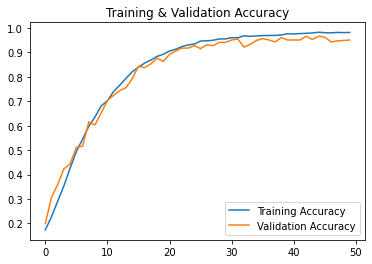

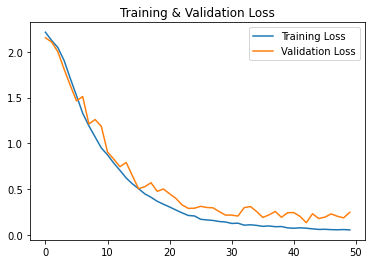

In [ ]:
# Plot the train result
## Get accuracy and val_accuracy histories
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

## Get accuracy and val_accuracy losses
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

## Plot accuracies result
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')

plt.legend()
plt.show() 

plt.figure()

## Plot losses result
plt.plot(epochs, loss, label ='Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title('Training & Validation Loss')

plt.legend()
plt.show()  

In [ ]:
train_score = modelv1d4.evaluate(train_generator)
validation_score = modelv1d4.evaluate(validation_generator)

print('Overall Train Accuracy : ', train_score[1])
print('Overall Validation Accuracy: ', validation_score[1])

5/5 [==============================] - 4s 664ms/step - loss: 0.2404 - accuracy: 0.9522
Overall Train Accuracy :  0.982875645160675
Overall Validation Accuracy:  0.95219886302948


## **Predict**

Actual class: Brown Spot
Predicted class: Brown Spot
 with the probabilities for each class as follow 
[1.6831287e-06 3.2223004e-05 3.8339792e-08 1.2466846e-07 9.9996459e-01
 3.4665053e-09 3.1944097e-08 7.8399331e-10 2.2406857e-07 1.0712338e-06]


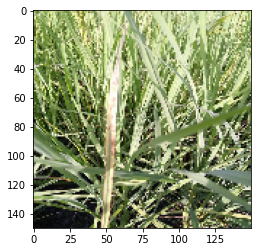

In [ ]:
# Test image preprocess
random_class = os.path.join(test_split_dir, random.choice(paddyleaf_classname))
random_image = random.choice(os.listdir(random_class))
selected_image = load_img(os.path.join(random_class, random_image), target_size=target_size)
x = img_to_array(selected_image)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.

# Predict the image
classes = modelv1d4.predict(x)
predicted_class = np.argmax(classes)

# Display the image and its predicted class
imageplot = plt.imshow(selected_image)
print("Actual class: {}".format(random_class.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(paddyleaf_classname[predicted_class], classes[0]))

Actual class: Bacterial Leaf Streak
Predicted class: Bacterial Leaf Streak
 with the probabilities for each class as follow 
[2.3306161e-07 9.9999630e-01 1.9792729e-08 5.6587325e-08 4.3469737e-07
 3.8468739e-09 4.9510312e-08 7.5036979e-08 2.6978944e-06 1.1577413e-08]


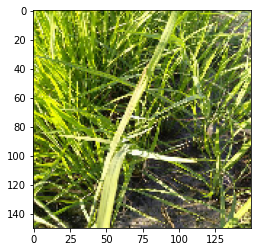

In [ ]:
# Test image preprocess
random_class = os.path.join(test_split_dir, random.choice(paddyleaf_classname))
random_image = random.choice(os.listdir(random_class))
selected_image = load_img(os.path.join(random_class, random_image), target_size=target_size)
x = img_to_array(selected_image)
x = np.expand_dims(x, axis=0)
x = np.vstack([x])
x /= 255.

# Predict the image
classes = modelv1d4.predict(x)
predicted_class = np.argmax(classes)

# Display the image and its predicted class
imageplot = plt.imshow(selected_image)
print("Actual class: {}".format(random_class.split('/')[-1]))
print("Predicted class: {}\n with the probabilities for each class as follow \n{}".format(paddyleaf_classname[predicted_class], classes[0]))

## **Save & Export Model**

In [ ]:
# Save the model
## Define temporary directory for save the model
MODEL_DIR = tempfile.gettempdir()
version = 1
diff = 4
version_path = os.path.join(MODEL_DIR, str(version))
export_path = os.path.join(version_path, str(diff))

## Ensure the temporary file
if os.path.isdir(export_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_path}

## Save the model
### tf format
modelv1d4.save(export_path, save_format="tf")
print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

### h5 keras format
saved_h5_format = './paddymodelv1d4.h5' 
modelv1d4.save(saved_h5_format)

INFO:tensorflow:Assets written to: /tmp/1/4/assets

export_path = /tmp/1/4
total 10632
drwxr-xr-x 2 root root    4096 Jun  5 17:39 assets
-rw-r--r-- 1 root root 1294886 Jun  5 17:39 keras_metadata.pb
-rw-r--r-- 1 root root 9577182 Jun  5 17:39 saved_model.pb
drwxr-xr-x 2 root root    4096 Jun  5 17:39 variables


In [ ]:
# Convert to .json format
## Install required library
!pip install tensorflowjs

## Path to .json directory
export_json_path = os.path.join(export_path, 'json_format')

## Ensure the temporary file
if os.path.isdir(export_json_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_json_path}

## Convert command
!tensorflowjs_converter --input_format=keras {saved_h5_format} {export_json_path}

##
!zip -r './jsonmodelv1d4.zip' {export_json_path}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.1 MB/s 
     |████████████████████████████████| 40 kB 7.3 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


  adding: tmp/1/4/json_format/ (stored 0%)
  adding: tmp/1/4/json_format/group1-shard41of69.bin (deflated 8%)
  adding: tmp/1/4/json_format/group1-shard66of69.bin (deflated 8%)
  adding: tmp/1/4/json_format/group1-shard46of69.bin (deflated 8%)
  adding: tmp/1/4/json_format/group1-shard32of69.bin (deflated 8%)
  adding: tmp/1/4/json_format/group1-shard53of69.bin (deflated 8%)
  adding: tmp/1/4/json_format/group1-shard30of69.bin (deflated 8%)
  adding: tmp/1/4/json_format/group1-shard11of69.bin (deflated 5%)
  adding: tmp/1/4/json_format/group1-shard12of69.bin (deflated 5%)
  adding: tmp/1/4/json_format/group1-shard7of69.bin (deflated 7%)
  adding: tmp/1/4/json_format/group1-shard48of69.bin (deflated 8%)
  adding: tmp/1/4/json_format/group1-shard6of69.bin (deflated 6%)
  adding: tmp/1/4/json_format/group1-shard47of69.bin (deflated 8%)
  adding: tmp/1/4/json_format/group1-shard2of69.bin (deflated 7%)
  adding: tmp/1/4/json_format/group1-shard51of69.bin (deflated 8%)
  adding: tmp/1/4/json

In [ ]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Use the tool to finally convert the model
tflite_model = converter.convert()

# Write TFLite model and its classes
tflite_model_file = 'paddymodel_v1_d4.tflite'

with open(tflite_model_file, "wb") as tf:
    tf.write(tflite_model)

with open('paddyclasses_v1_d4.txt', 'w') as classes:
    classes.write('\n'.join(paddyleaf_classname))

In [ ]:
try:
    files.download('paddymodel_v1_d4.tflite')
    files.download('paddyclasses_v1_d4.txt')
    files.download('jsonmodelv1d4.zip')
    
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>